# Self-Driving Car Behavorial Cloning in Simulation

In [2]:
%matplotlib inline

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Conv2D

Using TensorFlow backend.


In [3]:
#get samples from the driving log
def get_samples(filename):
  df = pd.read_csv(filename)
  X = df[['center','left','right']].values
  y = df['steering'].values
  return X, y

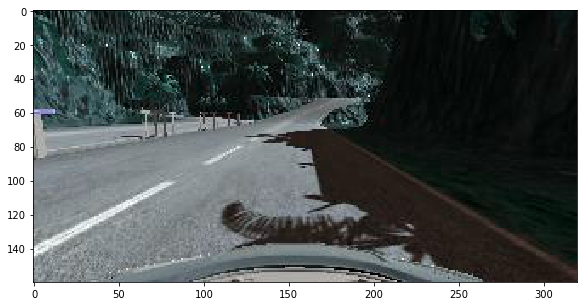

In [4]:
#Creation of the Training Set: To capture good driving behavior, I first recorded two laps using 
#center lane driving in a simulator. Here is an example image of center lane driving:

X1, y1 = get_samples('./data/driving_log_track2_clockwise1.csv')
name = './data/IMG/' + X1[0][0].strip().split('/')[-1]
image = cv2.imread(name)
plt.figure(figsize=(10,5))
plt.imshow(image)   #each frame is of size 160x320 RGB Image
plt.show()

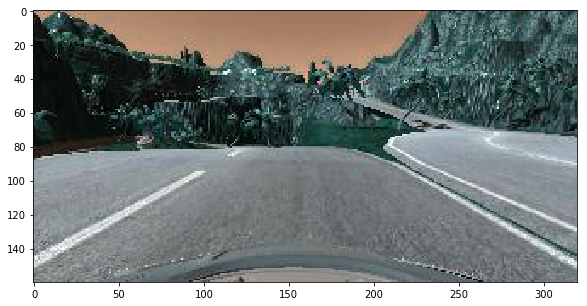

In [5]:
#To avoid overfitting to the left turn making behavior in the data, I also recorded two 
#laps using counter-clockwise center lane driving in the simulator. Here is an example image 
#of the counter-clockwise center lane driving:
X2, y2 = get_samples('./data/driving_log_track2_counterclockwise1.csv')
name = './data/IMG/' + X2[0][0].strip().split('/')[-1]
image = cv2.imread(name)
plt.figure(figsize=(10,5))
plt.imshow(image)   #each frame is of size 160x320 RGB Image
plt.show()

In [6]:
X1, y1 = get_samples('./data/driving_log_track2_clockwise1.csv')
X2, y2 = get_samples('./data/driving_log_track2_counterclockwise1.csv')
X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((y1, y2), axis=0)

In [7]:
# Image Preprocessing to remove irrelevant parts and to deal with shadow (light variation)
def preprocess(image):
  yuv = cv2.cvtColor(image,cv2.COLOR_BGR2YUV) #convert from BGR to YUV
  hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
  yuv[:,:,2] = hsv[:,:,2] #replace yuv's v channel with hsv's v channel to deal with shadows
  image = image[50:-20, 30:-30,:] #cropping
  image = image/127.5 - 1.0 #normalization
  return image

In [8]:
# Data Augmentation: Adding left camera images and right camera images further avoids overfitting 
# and enables the convolutional neural network to learn to correct its deviation from the center of the lane.

#randomly choose left, right or center images and load images
def load_image(X_sample, angle, is_training):
  if is_training and np.random.random() > 0.8:
    c = np.random.randint(1, 3) # randomly choose left or right image
    name = './data/IMG/' + X_sample[c].strip().split('/')[-1]
    if c == 1:
      angle = float(angle) + 0.2  #correct right camera steering angle by 0.2
    elif c == 2:
      angle = float(angle) - 0.2  #correct left camera steering angle by -0.2

    image = cv2.imread(name)
    image = preprocess(image)
    return image, angle
  else: #chose center images most of the time
    name = './data/IMG/' + X_sample[0].strip().split('/')[-1]
    angle = float(angle)
    image = cv2.imread(name)
    image = preprocess(image)
    return image, angle

In [9]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)

In [10]:
def load_data(X_sample, angle, is_training):
  image, angle = load_image(X_sample, angle, is_training)
  return image, angle

In [11]:
#generator that is used to generate batches for training and testing/validation
def generator(X, y, batch_size, is_training):
  assert(len(X) == len(y))
  num_samples = len(X)
  while 1:
    shuffle(X, y)
    for offset in range(0, num_samples, batch_size):
      X_samples = X[offset:offset+batch_size]
      y_samples = y[offset:offset+batch_size]
 
      images = []
      angles = []
      for X_sample, y_sample in zip(X_samples, y_samples):
        image, angle = load_data(X_sample, y_sample, is_training)
        images.append(image)
        angles.append(angle)
        
      X_data = np.array(images)
      y_data = np.array(angles)
      yield shuffle(X_data, y_data)

In [12]:
batch_size = 32
samples_per_epoch = len(train_X)
print('samples_per_epoch=', samples_per_epoch)
steps_per_epoch = int(samples_per_epoch/batch_size) #the number of batches to draw from the generator at each epoch
print('steps_per_epoch=',steps_per_epoch)
nb_val_samples=len(val_X)
print('number_val_samples=', nb_val_samples)
validation_steps=int(nb_val_samples/batch_size)
print('validation_steps=', validation_steps)
train_generator = generator(train_X, train_y, batch_size, is_training=True)
validation_generator = generator(val_X, val_y, batch_size, is_training=False)

samples_per_epoch= 9196
steps_per_epoch= 287
number_val_samples= 2300
validation_steps= 71


In [13]:
model = Sequential()
model.add(Conv2D(24, (7,7), strides=(2,2), activation = 'relu', input_shape=(90,260,3)))
model.add(Conv2D(36, (5,5), strides=(2,2), activation = 'relu'))
model.add(Conv2D(48, (5,5), strides=(2,2), activation = 'relu'))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1164, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))

#traning the model and evaluate it using the validation dataset for 3 epochs
model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, epochs=3)

model.save('model.h5') #this output model is used by the simulator to run the vehicle

Epoch 1/3
287/287 [==============================] - 44s - loss: 0.1380 - val_loss: 0.1230
Epoch 2/3
287/287 [==============================] - 41s - loss: 0.1062 - val_loss: 0.0957
Epoch 3/3
287/287 [==============================] - 39s - loss: 0.0948 - val_loss: 0.0919


In [14]:
#running the model on the test dataset

X1, y1 = get_samples('./data/driving_log_track2_clockwise2.csv')
X2, y2 = get_samples('./data/driving_log_track2_counterclockwise2.csv')
test_X = np.concatenate((X1, X2), axis=0)
test_y = np.concatenate((y1, y2), axis=0)
test_generator = generator(test_X, test_y, batch_size, is_training=False)

number_test_samples = len(test_X)
print('number_test_samples=', number_test_samples) 
test_steps = int(number_test_samples/batch_size)
print('test_steps=', test_steps) 
model.evaluate_generator(test_generator, steps=test_steps)

number_test_samples= 11880
test_steps= 371


0.091548998895693678